In [2]:
import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions.categorical import Categorical
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import os

In [3]:
# The CNN network as our agent 
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.features=nn.Sequential(
            nn.Sequential(
              nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
              nn.BatchNorm2d(32),
              nn.ReLU()
            ),
        )

        self.fc = nn.Linear(32*10*10, 10*10) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.softmax(x, dim=-1) 

In [4]:
class Environment():
    def __init__(self):
        self.shape = (10,10)
        self.ships = np.array([5,4,3,3,2])
        self.total_ships_lengths = self.ships.sum()

        self.shots = []
        self.state = np.zeros(self.shape, dtype='float32')
        self.ground_truth = np.zeros(self.shape, dtype='float32')
        self.done = False
        self.open_place = np.ones(100)

        self.place_ship()
        
    
    def place_ship(self):
        ''' Places ships on the grid
        '''
        for n,size in enumerate(self.ships):
            success = False
            while not success:
                horizontal=random.randint(0,1)
                x = random.randint(0, self.shape[0]-1)
                y = random.randint(0, self.shape[1]-1)
                if horizontal == 0: 
                    if y + size <= self.shape[1] and np.sum(self.ground_truth[x, y:y+size]) == 0:
                        self.ground_truth[x, y:y+size] = 1
                        success = True
                else:
                    if x + size <= self.shape[0] and np.sum(self.ground_truth[x:x+size, y]) == 0:
                        self.ground_truth[x:x+size, y] = 1
                        success = True

    def reset(self):
        """Resets the environment
        """
        self.shots = []
        self.state = np.zeros(self.shape, dtype='float32')
        self.ground_truth = np.zeros(self.shape, dtype='float32')
        self.done = False
        self.open_place = np.ones(100)

        self.place_ship()
        return self.get_state(),self.open_place.copy()
    
    def resetwithgt(self, gt):
        """Resets the environment with groundtruth
        used for testing with fixed samples
        """
        self.shots = []
        self.state = np.zeros(self.shape, dtype='float32')
        self.ground_truth = gt
        self.done = False
        self.open_place = np.ones(100)

        return self.get_state(),self.open_place.copy()
    
    def get_state(self):
        """get the 3 channel state
        """
        output_state = np.zeros((3,10,10))
        output_state[0] = (self.state==1)
        output_state[1] = (self.state==0)
        output_state[2] = (self.state==-1)
        output_state = output_state*2 - 1.0
        return torch.from_numpy(output_state).type(torch.FloatTensor)

    def step(self, guess):
        """ Perform an action on the environment
        :returns: A tuple containing the next state, reward, done (bool)
        """
        x,y = guess
        reward = -1
        self.open_place[x*10+y] = 0.
        
        if self.state[x,y] == 0 and self.ground_truth[x,y] == 1:
            self.state[x,y] = 1
            self.shots.append(1)
            reward = 1
            if sum(self.shots) == self.total_ships_lengths:
                self.done = True
        else:
            if self.ground_truth[x,y] == 0:
                self.state[x,y] = -1
            self.shots.append(0)
        return self.get_state(), reward, self.done, self.open_place.copy()

In [5]:
# reward function
def rewards_calculator(raw_reward, gamma=0.99):
    raw_reward[raw_reward==-1] = 0
    weighted = [(item- (raw_reward[i:].sum()/(100-i))) * (gamma ** i) for i, item in enumerate(raw_reward)]
    cum = np.cumsum(weighted[::-1])[::-1] 
    return cum * (gamma ** -np.arange(len(raw_reward)))

In [6]:
# Policy gradient training process
def reinforce(env, policy, num_episodes=2000,
              batch_size=20, step_size=0.001, gamma=1.0):

    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 0
    
    optimizer = optim.Adam(policy.parameters(), lr=step_size)
    
    for ep in range(num_episodes):
        s_0, open_place = env.reset()
        states = []
        rewards = []
        actions = []
        complete = False
        while complete == False:
            action_probs = policy(s_0.unsqueeze(0))[0].detach()
            op_probs = action_probs * torch.from_numpy(open_place).type(torch.FloatTensor)

            m = Categorical(op_probs)
            action = m.sample()
            s_1, r, complete, open_place = env.step(divmod(action.item(),10))
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If complete, batch data
            if complete:
                batch_rewards.extend(rewards_calculator(np.array(rewards), gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.stack(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    prob = policy(state_tensor)
                    selected_prob = prob[np.arange(len(action_tensor)), action_tensor]
                    nonzero_index = (selected_prob > 0)
                    reward_nonzero = reward_tensor[nonzero_index]
                    prob_nonzero = selected_prob[nonzero_index]
                    
                    selected_logprobs = reward_nonzero * torch.log(prob_nonzero)
                    loss = -selected_logprobs.mean()
                    
                    loss.backward()
                    # Apply gradients
                    torch.nn.utils.clip_grad_norm_(policy.parameters(), 5)
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 0
                    
                # Print running average
                    print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
                
    return total_rewards

In [7]:
# test with given samples
def test(env, policy, samples):
    
    total_rewards = []

    for i,sample in enumerate(samples):
        s_0, open_place = env.resetwithgt(sample)
        rewards = []
        complete = False
        while complete == False:

            action_probs = policy(s_0.unsqueeze(0))[0].detach().numpy()
            action = np.argmax(action_probs * open_place)
            s_1, r, complete, open_place = env.step(divmod(action,10))
            
            rewards.append(r)
            s_0 = s_1
            
            if complete:
                total_rewards.append(sum(rewards))
                
    return total_rewards

In [8]:
def train(env,policy):
    rewards = reinforce(env, policy, num_episodes=5000, batch_size=20, step_size=0.001, gamma=0.5)
    window = 10

    stepcount = 34 - np.array(rewards)
    smoothed_step = [np.mean(stepcount[i-30:i+1]) if i > window 
                        else np.mean(stepcount[:i+1]) for i in range(len(stepcount))]
    plt.plot(stepcount)
    plt.plot(smoothed_step)
    plt.ylabel('Steps')
    plt.xlabel('Episodes')
    plt.show()


backed
Ep: 20 Average of last 10: -26.60backed
Ep: 40 Average of last 10: -24.50backed
Ep: 60 Average of last 10: -27.00backed
Ep: 80 Average of last 10: -29.60backed
Ep: 100 Average of last 10: -26.30backed
Ep: 120 Average of last 10: -31.50backed
Ep: 140 Average of last 10: -18.00backed
Ep: 160 Average of last 10: -23.10backed
Ep: 180 Average of last 10: -24.10backed
Ep: 200 Average of last 10: -27.80backed
Ep: 220 Average of last 10: -18.20backed
Ep: 240 Average of last 10: -18.90backed
Ep: 260 Average of last 10: -32.00backed
Ep: 280 Average of last 10: -28.20backed
Ep: 300 Average of last 10: -24.70backed
Ep: 320 Average of last 10: -22.10backed
Ep: 340 Average of last 10: -21.00backed
Ep: 360 Average of last 10: -22.00backed
Ep: 380 Average of last 10: -26.50backed
Ep: 400 Average of last 10: -30.60backed
Ep: 420 Average of last 10: -25.40backed
Ep: 440 Average of last 10: -22.40backed
Ep: 460 Average of last 10: -23.90backed
Ep: 480 Average of last 10: -21.50backed
Ep: 500 Avera

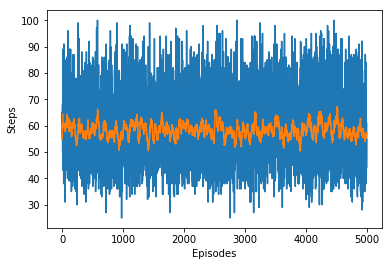

In [24]:
env = Environment()
policy = None
if os.path.exists("battle_reinforce.pt"):
    policy = torch.load("battle_reinforce.pt")
else:
    policy = Policy()
train(env,policy)

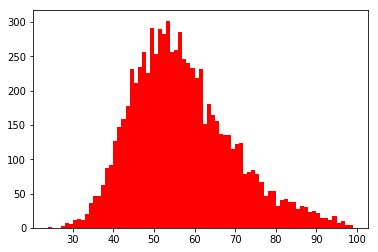

In [29]:
samples = np.load("sample.npy")
samples.shape
total_rewards = test(Environment(),policy, samples)
steps = 34 - np.array(total_rewards)
plt.hist(steps, steps.max()-steps.min(), facecolor='red')
plt.show()

In [30]:
torch.save(policy, "battle_reinforce.pt")

c:\users\think\appdata\local\programs\python\python35\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
